In [3]:
# Imports

import os 
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
CHESSBOARD_DIR = './camera_cal/*.jpg'

NX = 9
NY = 6

def loadChessboardImages(path):

    # Create a list of image files
    img_paths = glob.glob(path)

    # Read all images into a list
    images = []
    for img_loc in img_paths:
        img = cv2.imread(img_loc)
        images.append(img)
        
    return images

chssbrd_imgs = loadChessboardImages(CHESSBOARD_DIR)

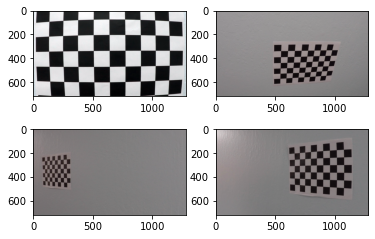

In [4]:
# preview of the images 

fig, axarr = plt.subplots(2,2)
axarr[0,0].imshow(chssbrd_imgs[0])
axarr[0,1].imshow(chssbrd_imgs[1])
axarr[1,0].imshow(chssbrd_imgs[2])
axarr[1,1].imshow(chssbrd_imgs[3])

In [5]:
img_size = chssbrd_imgs[0].shape[::-1][1:]

In [6]:
def findChessboardCorners(gray_imgs, nx, ny):
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
    imgps = []
    objps = []
    for img in gray_imgs:
        # Detect chessboard corners
        found, corners = cv2.findChessboardCorners(img, (nx,ny), None)
        if not found:
            continue
        imgps.append(corners)
        objps.append(objp)
    return imgps, objps

imgps, objps = findChessboardCorners(chssbrd_imgs, NX, NY)

In [7]:
def calibrate_camera(imgps, objps, img_size):
    """Returns camera calibration matrix and distortion coefficients"""
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objps, imgps, img_size, None, None)
    return mtx, dist

MTX, DIST = calibrate_camera(imgps, objps, img_size)

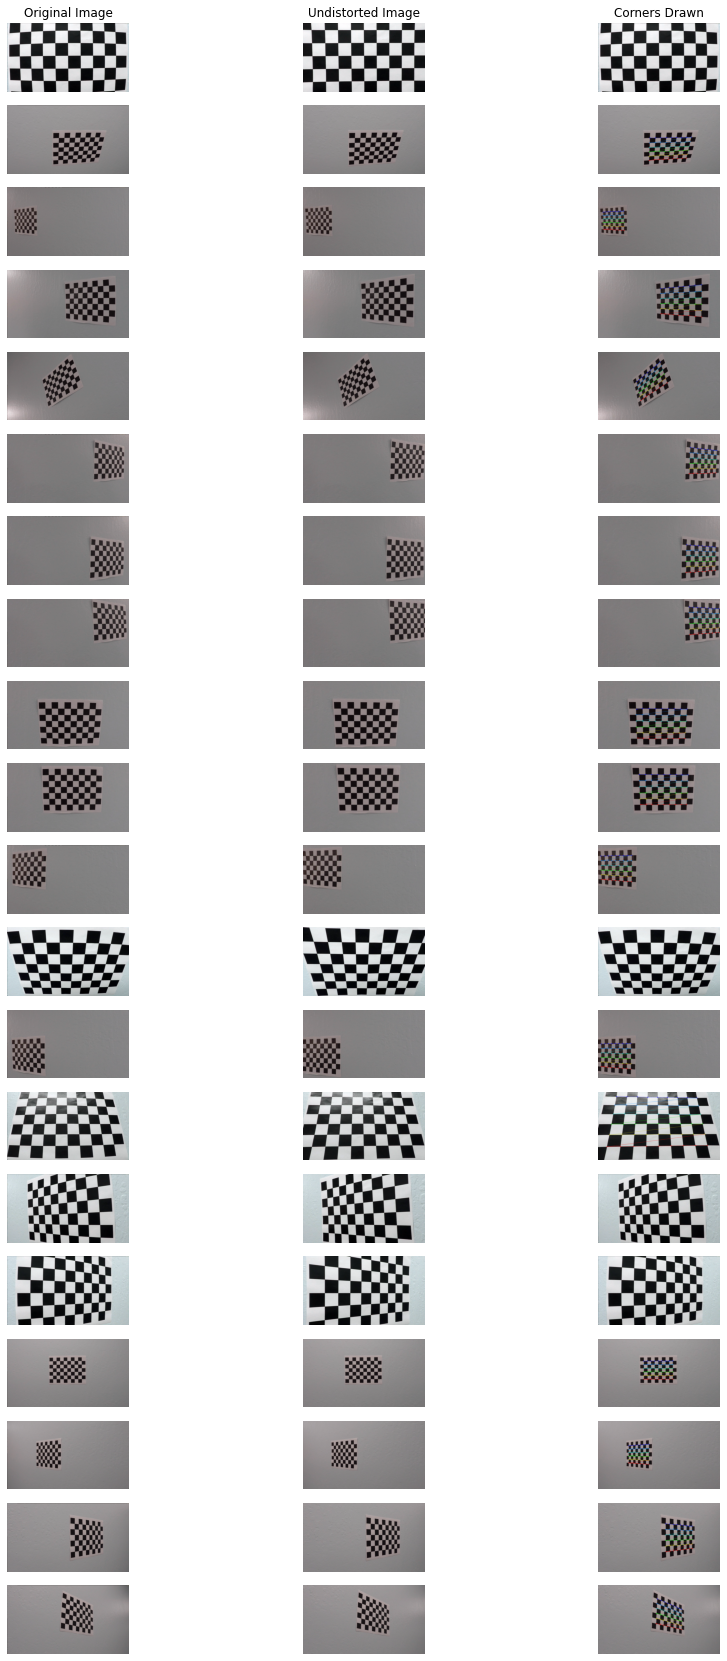

In [8]:
# Set up figure for plotting
fig, axarr = plt.subplots(len(chssbrd_imgs), 3)
fig.set_size_inches(15, 30)

undist_imgs = []
corners_drawn = []

# Loop through images, undistory them, and draw corners on undistorted versions.
for i, img in enumerate(chssbrd_imgs):
    # Set column headings on figure
    if i == 0:
        axarr[i, 0].set_title("Original Image")
        axarr[i, 1].set_title("Undistorted Image")
        axarr[i, 2].set_title("Corners Drawn")
        
    # Generate new undistorted image
    undist = cv2.undistort(img, MTX, DIST, None, MTX)
    undist_imgs.append(undist)
    
    # Generate new image with corner points drawn
    undist_copy = undist.copy()
    undist_grey = cv2.cvtColor(undist_copy, cv2.COLOR_BGR2GRAY)
    found, corners = cv2.findChessboardCorners(undist_grey, (NX, NY), None)
    if found:
        drawn = cv2.drawChessboardCorners(undist_copy, (NX, NY), corners, found)
        corners_drawn.append(drawn)
    else:
        drawn = img
        corners_drawn.append(drawn)
    
    # Plot images on figure
    axarr[i, 0].imshow(img)
    axarr[i, 0].axis('off')
    axarr[i, 1].imshow(undist)
    axarr[i, 1].axis('off')
    axarr[i, 2].imshow(drawn)
    axarr[i, 2].axis('off')

In [9]:
TEST_IMG = ".\\test_images\\straight_lines1.jpg"
lane_test_img = cv2.imread(TEST_IMG)
lane_test_img_rgb = cv2.cvtColor(lane_test_img, cv2.COLOR_BGR2RGB)
lane_test_undist = cv2.undistort(lane_test_img_rgb, MTX, DIST, None, MTX)

In [10]:
TEST_IMG2 = ".\\test_images\\test5.jpg"
lane_test_img2 = cv2.imread(TEST_IMG2)
lane_test_img2_rgb = cv2.cvtColor(lane_test_img2, cv2.COLOR_BGR2RGB)
lane_test_undist2 = cv2.undistort(lane_test_img2_rgb, MTX, DIST, None, MTX)

In [4]:
def preprocess_image(img):
    img = cv2.GaussianBlur(img, (3, 3), 0)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray

def extract_yellow_and_white_lines(img):
    sthresh=(140,255)
    lthresh=(120, 255)

    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    L = hls_img[:,:,1]
    S = hls_img[:,:,2]
    hls_mask = np.zeros_like(S)
    hls_mask[(S >= sthresh[0]) & (S <= sthresh[1]) & (L > lthresh[0]) & (L <= lthresh[1])] = 1

    return hls_mask

def find_sobel_edges(gray, hls_mask, s_thresh):
    x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    x = np.absolute(x)
    x = np.uint8(255 * x / np.max(x))

    sobel_x = np.zeros_like(x)
    sobel_x[(x >= s_thresh[0]) & (x <= s_thresh[1])] = 1

    y = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    y = np.absolute(y)
    y = np.uint8(255 * y / np.max(y))

    sobel_y = np.zeros_like(y)
    sobel_y[(y >= s_thresh[0]) & (y <= s_thresh[1])] = 1

    magnitude = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
    magnitude = np.uint8(255 * magnitude / np.max(magnitude))
    magnitude_binary = np.zeros_like(magnitude)
    magnitude_binary[(magnitude > 30) & (magnitude < 100)] = 1 

    direction = np.arctan2(sobel_y, sobel_x)

    direction_binary = np.zeros_like(direction)
    direction_binary[(direction > 0.8) & (direction < 1.2)] = 1

    sobel_gradient = cv2.bitwise_or(cv2.threshold(sobel_x, 25, 200, cv2.THRESH_BINARY)[1], cv2.threshold(sobel_y, 25, 200, cv2.THRESH_BINARY)[1])
    gradient = np.zeros_like(hls_mask)
    gradient[((sobel_x == 1) & (sobel_y == 1)) | ((magnitude_binary == 1) & (direction_binary == 1))] = 1
    final_binary = cv2.bitwise_or(hls_mask, gradient)

    return final_binary

def process_image(image):
    gray = preprocess_image(image)
    hls_mask = extract_yellow_and_white_lines(image)
    final_binary = find_sobel_edges(gray, hls_mask, (25, 200))

    return final_binary

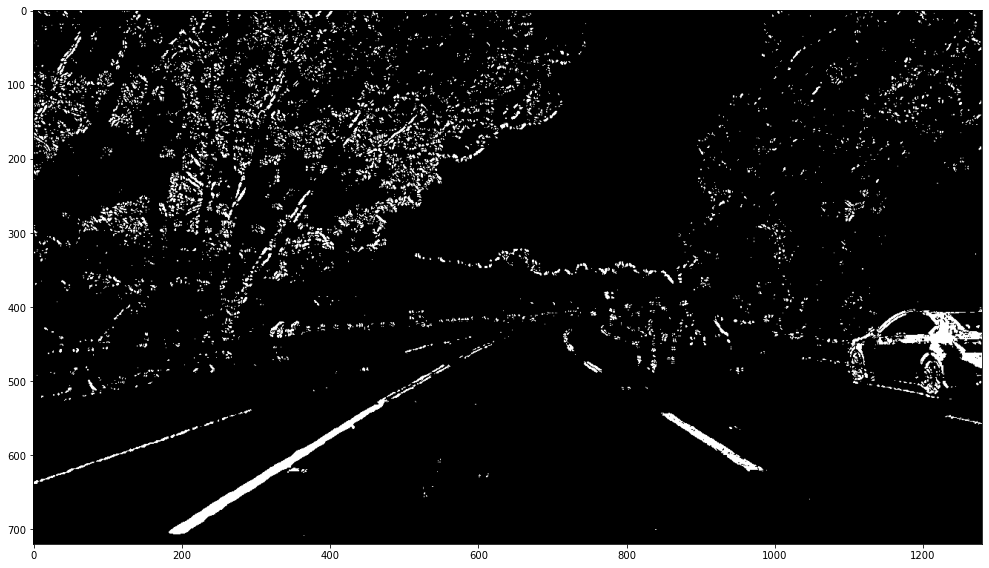

In [12]:
final_binary = process_image(lane_test_undist2)
fig, axarr = plt.subplots(1,1)
fig.set_size_inches(17, 10)
plt.imshow(final_binary, cmap='gray')

In [5]:
def warp_image(img):
    
    """ Returns an image with the birds eye perspective, and the inverse perspective transform """
    try:
        # Validate input image
        if img is None or img.size == 0:
            raise ValueError("Input image is not valid")
        
        # Define source and destination points
        x = img.shape[1]
        y = img.shape[0]
        source_points = np.float32([
            [0.117 * x, y],
            [(0.5 * x) - (x*0.078), (2/3)*y],
            [(0.5 * x) + (x*0.078), (2/3)*y],
            [x - (0.117 * x), y]
        ])
        destination_points = np.float32([
            [0.25 * x, y],
            [0.25 * x, 0],
            [x - (0.25 * x), 0],
            [x - (0.25 * x), y]
        ])

        # Compute perspective transform and warp image
        perspective_transform = cv2.getPerspectiveTransform(source_points, destination_points)
        inverse_perspective_transform = cv2.getPerspectiveTransform( destination_points, source_points)
        warped_img = cv2.warpPerspective(img, perspective_transform, None, flags=cv2.INTER_LINEAR)

        return warped_img, inverse_perspective_transform
    
    except Exception as e:
        print(f"Error in warp_image: {e}")
        return None, None


In [6]:
def plot_lines(image):
    
    # create a copy of the input image
    image_cp = image.copy()

    # Define source points
    x = image_cp.shape[1]
    y = image_cp.shape[0]
    source_points = np.float32([
        [0.117 * x, y],
        [(0.5 * x) - (x*0.078), (2/3)*y],
        [(0.5 * x) + (x*0.078), (2/3)*y],
        [x - (0.117 * x), y]
    ])

    # Draw source points on the original image
    draw_poly = cv2.polylines(image_cp, [source_points.astype(int)], True, (255, 0, 0), 5)

    return draw_poly


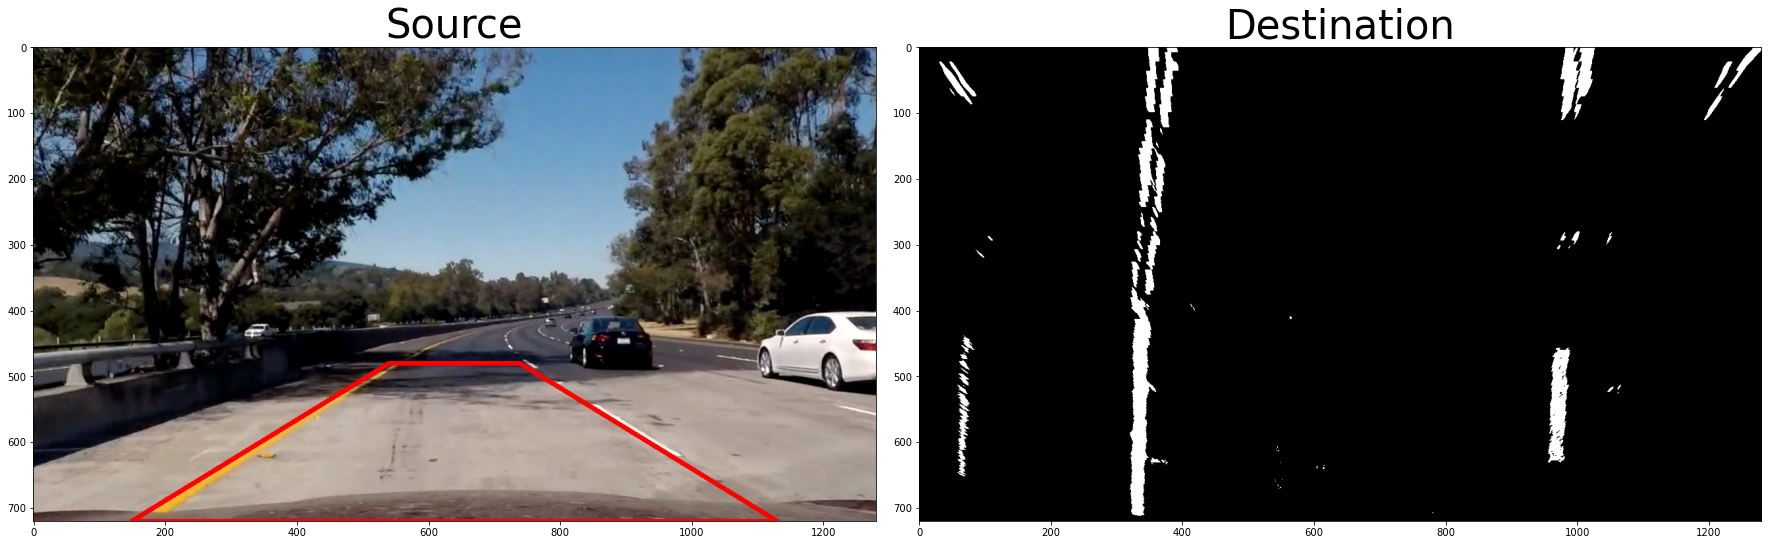

In [15]:
birdseye_result, Minv = warp_image(final_binary)

draw_poly = plot_lines(lane_test_undist2)

# Display source and destination images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
fig.tight_layout()

ax1.imshow(draw_poly)
ax1.set_title('Source', fontsize=40)
ax2.imshow(birdseye_result, cmap='gray')
ax2.set_title('Destination', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0)

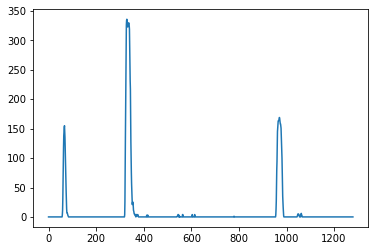

In [16]:
histogram = np.sum(birdseye_result[int(birdseye_result.shape[0]/2):,:], axis=0)
plt.figure();
plt.plot(histogram);

In [7]:
def track_lanes(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    midpoint = int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    nwindows = 9
    margin = 100
    minpix = 50
    window_height = int(binary_warped.shape[0]/nwindows)

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    leftx_current = leftx_base
    rightx_current = rightx_base

    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height

        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)

        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        if len(good_left_inds) > minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return out_img, left_fit, right_fit, left_fitx, right_fitx, ploty, histogram

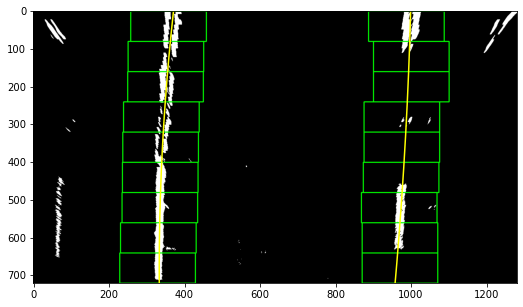

In [18]:
# Call the track_lanes_initialize function
out_img, left_fit, right_fit, left_fitx, right_fitx, ploty, _ = track_lanes(birdseye_result)

# Create a new plot
fig, ax = plt.subplots(figsize=(10,5))

# Plot the output image
ax.imshow(out_img)

ax.plot(left_fitx, ploty, color='yellow')
ax.plot(right_fitx, ploty, color='yellow')
#ax.show()

In [8]:
def track_lanes_update(binary_warped, left_fit, right_fit):
    """Detect lane line by searching around detection of previous sliding window detection"""
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    margin = 100
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_lane_inds, right_lane_inds, ploty, left_fitx, right_fitx

In [20]:

left_lane_inds, right_lane_inds, ploty, left_fitx, right_fitx = track_lanes_update(birdseye_result, left_fit, right_fit)

In [9]:
def get_lane_lines(binary_warped, left_lane_inds, right_lane_inds, left_fitx, right_fitx, ploty):

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    margin = 100

    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return result

Text(0.5, 1.0, 'Binary warped image with lane lines and search window')

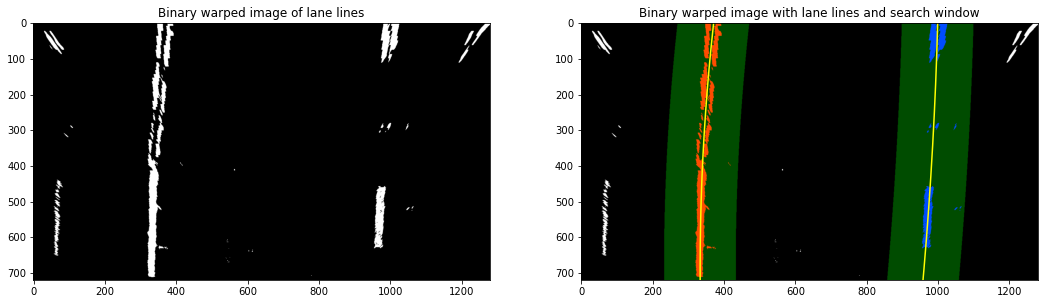

In [22]:
result = get_lane_lines(birdseye_result, left_lane_inds, right_lane_inds, left_fitx, right_fitx, ploty)

# Plot the figure
fig, axarr = plt.subplots(1,2)
fig.set_size_inches(18, 5)
axarr[0].imshow(birdseye_result, cmap='gray')
axarr[1].imshow(result)
axarr[1].plot(left_fitx, ploty, color='yellow')
axarr[1].plot(right_fitx, ploty, color='yellow')
axarr[0].set_title("Binary warped image of lane lines")
axarr[1].set_title("Binary warped image with lane lines and search window")

In [10]:
def project_lane_line(original_image, binary_warped, ploty, left_fitx, right_fitx, m_inv):
    # Create an image to draw the lines on
    color_warp = np.zeros_like(original_image).astype(np.uint8)
        
    # Generate the points to draw the lane lines
    left_line_pts = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line_pts = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    lane_pts = np.hstack((left_line_pts, right_line_pts))
    
    # Draw the lane onto the color_warp image
    cv2.fillPoly(color_warp, np.int_([lane_pts]), (0, 255, 0))
    
    # Warp the lane back to the original image space using the inverse perspective transform
    lane_warped = cv2.warpPerspective(color_warp, m_inv, (original_image.shape[1], original_image.shape[0]))
    
    # Combine the original image with the lane image
    result = cv2.addWeighted(original_image, 1, lane_warped, 0.3, 0)
    return result

In [24]:
result = project_lane_line(lane_test_undist2, birdseye_result, ploty, left_fitx, right_fitx, Minv)

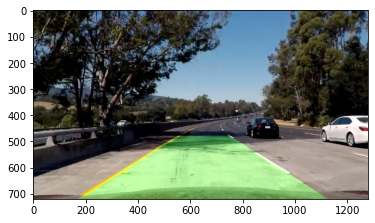

In [25]:
plt.figure()
plt.imshow(result)

In [11]:
def get_lane_curvature(ploty, leftx, rightx, lefty, righty, unit="m"):
    
    """Returns curvature of the lane in meters."""

    # Define y-value where we want radius of curvature (bottom of image)
    y_eval = np.max(ploty)

    # Define conversion factors
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    try:
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    except TypeError:
        # Return large value if the lane lines cannot be detected
        return 1e9, 1e9

    # Calculate the new radii of curvature
    left_curvem = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curvem = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curvem, right_curvem

def get_car_position(img, left_fit, right_fit):
    
    """Returns the position of the car relative to the center of the lane in meters."""
    
    if left_fit is None or right_fit is None:
        raise ValueError("Lane lines not detected")

    img_width = img.shape[1]
    lane_center = (left_fit[-1] + right_fit[-1]) / 2.0
    pixel_offset = img_width / 2.0 - lane_center
    meter_per_pixel = 3.7 / 700  # meters per pixel in x dimension
    offset = meter_per_pixel * pixel_offset  # offset in meters
    
    return offset

In [27]:
nonzero = birdseye_result.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

curve = get_lane_curvature(ploty, leftx, rightx, lefty, righty, unit="m")
print(curve)

center_offset = get_car_position(lane_test_img_rgb, left_fit, right_fit)
print(str(center_offset) + 'cm')

(2046.1500643647212, 3882.1467799094303)
-0.23745566254230482cm


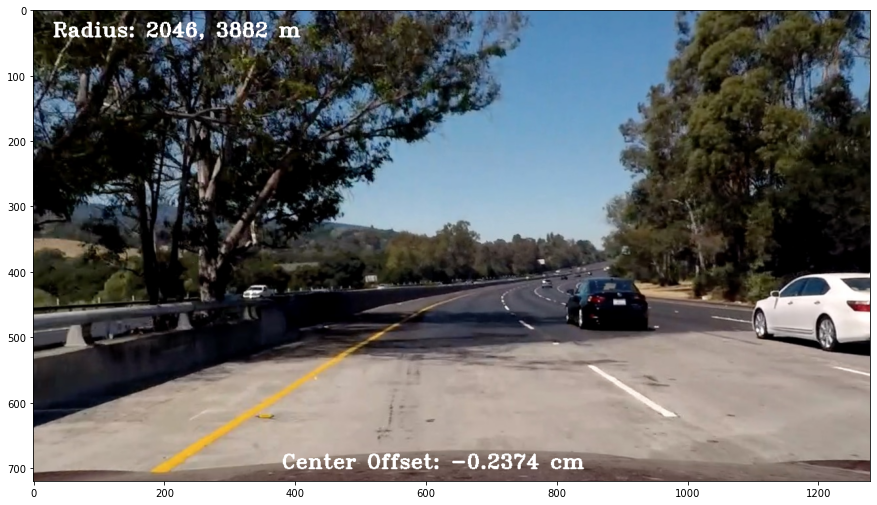

In [28]:
img_cp = lane_test_undist2.copy()

font = cv2.FONT_HERSHEY_TRIPLEX

left_line_curve = int(curve[0])
right_line_curve = int(curve[1])

cv2.putText(img_cp, 'Radius: '+str(left_line_curve)+', '+str(right_line_curve)+' m', (30, 40), font, 1, (255,255,255), 2)
#cv2.putText(img_cp,'Center Offset: '+str(center_offset)[:7]+' cm',(30,100), font, 1,(255,255,255),2)
cv2.putText(img_cp,'Center Offset: '+str(center_offset)[:7]+' cm',(380,700), font, 1,(255,255,255),2)
plt.figure(figsize = (15, 15))
plt.imshow(img_cp)



(720, 1280, 3)

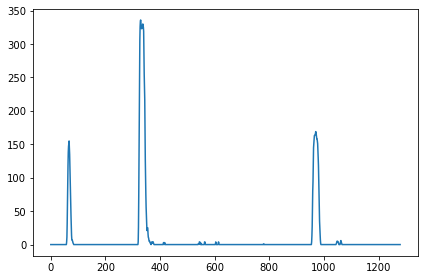

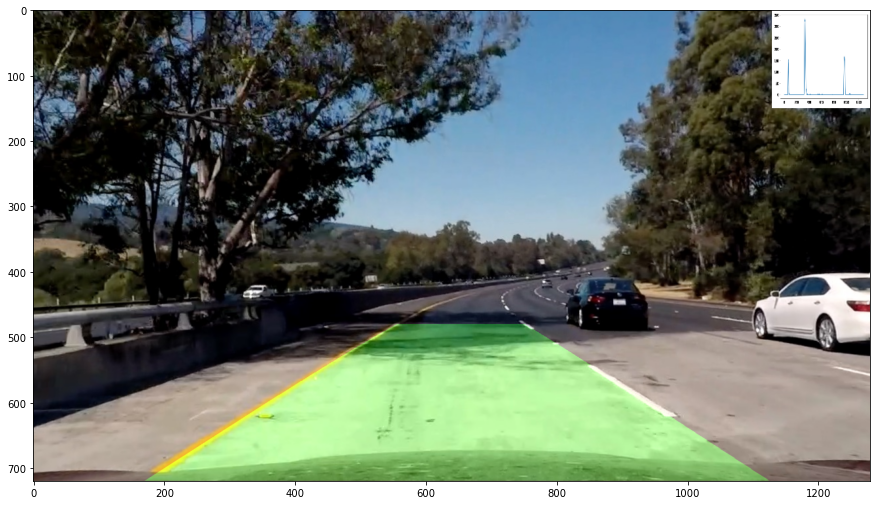

In [29]:
fig.patch.set_facecolor("None")
ax.patch.set_alpha(0.5)

plt.plot(histogram)
plt.tight_layout()

fig = plt.gcf()
fig.canvas.draw()
plot_img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
plot_img = plot_img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
plot_img = cv2.resize(plot_img, (150, 150))

#result = np.concatenate((img_cp, np.zeros((img_cp.shape[0], 150, 3), dtype=np.uint8)), axis=1)
result[0:150, img_cp.shape[1]-150:img_cp.shape[1], :] = plot_img

plt.figure(figsize = (15, 15))
plt.imshow(result)



img_cp.shape

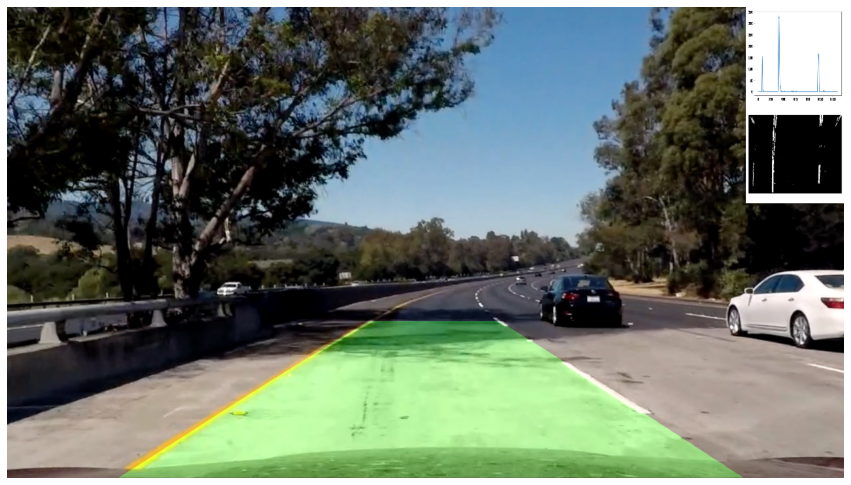

In [30]:
fig.patch.set_alpha(0.5)
plt.imshow(birdseye_result,cmap='gray')

plt.axis('off')
plt.tight_layout()

fig = plt.gcf()
fig.canvas.draw()

plot_img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
plot_img = plot_img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
plot_img = cv2.resize(plot_img, (150, 150))

#result = np.concatenate((img_cp, np.zeros((img_cp.shape[0], 150, 3), dtype=np.uint8)), axis=1)
result[150:300, img_cp.shape[1]-150:img_cp.shape[1], :] = plot_img


plt.close()

plt.figure(figsize = (15, 15))
plt.axis('off')
plt.imshow(result)

#plt.imshow(cv2.resize(birdseye_result,(150,150)))



In [31]:
def run_pipeline(image):
    # Preprocess Image
    lane_img_rgb = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    lane_img_undist = cv2.undistort(lane_img_rgb, MTX, DIST, None, MTX)

    # In process_image the image is passed to extract a gray image, hls_mask, and the sobel_edges

    binary_image = process_image(lane_img_undist)

    # 3. Perspective Transform, and Inverse Perspective Transform (Minv)

    birdseye_image, Minv = warp_image(binary_image)
    draw_poly = plot_lines(lane_img_undist)

    # 4. Track the Lanes

    out_img, left_fit, right_fit, left_fitx, right_fitx, ploty, histogram = track_lanes(birdseye_image)

    left_lane_inds, right_lane_inds, ploty, left_fitx, right_fitx = track_lanes_update(birdseye_image, left_fit, right_fit)

    result = project_lane_line(lane_img_undist, birdseye_image, ploty, left_fitx, right_fitx, Minv)

    # 5. Display Information: (This is extra)
    
    # Find the lane curvature and car position and draw it on the image   

    nonzero = birdseye_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    curve = get_lane_curvature(ploty, leftx, rightx, lefty, righty, unit="m")

    center_offset = get_car_position(lane_img_undist, left_fit, right_fit)
  
    font = cv2.FONT_HERSHEY_TRIPLEX
    
    left_line_curve = int(curve[0])
    right_line_curve = int(curve[1])

    #cv2.putText(result, 'Radius: '+str(left_line_curve)+', '+str(right_line_curve)+' m', (30, 40), font, 1, (255,255,255), 2)
    cv2.putText(result,'Center Offset: '+str(center_offset)[:7]+' cm',(380,700), font, 1,(255,255,255),2)
       
    
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

    # 6. Adding the Histogram
    plt.plot(histogram, alpha=0.5)
    plt.tight_layout()
    
    fig = plt.gcf()
    
    
    plt.close()
    fig.canvas.draw()
    plot_img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    plot_img = plot_img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plot_img = cv2.resize(plot_img, (150, 150))

    #result = np.concatenate((img_cp, np.zeros((img_cp.shape[0], 150, 3), dtype=np.uint8)), axis=1)
    result[0:150, result.shape[1]-150:result.shape[1], :] = plot_img
    
    # 7. Adding the Birds eye image
    
    plt.imshow(birdseye_image, cmap='gray')

    plt.axis('off')
    plt.tight_layout()

    fig = plt.gcf()
    
    plt.close()
    fig.canvas.draw()
    plot_img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    plot_img = plot_img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plot_img = cv2.resize(plot_img, (150, 150))

    #result = np.concatenate((img_cp, np.zeros((img_cp.shape[0], 150, 3), dtype=np.uint8)), axis=1)
    result[150:300, img_cp.shape[1]-150:img_cp.shape[1], :] = plot_img
    
    
    return result

In [14]:
def run_alt_pipeline(image):
    # Preprocess Image
    lane_img_rgb = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    #lane_img_undist = cv2.undistort(lane_img_rgb, MTX, DIST, None, MTX)
    img_cp = lane_img_rgb.copy()

    # In process_image the image is passed to extract a gray image, hls_mask, and the sobel_edges

#    binary_image = process_image(lane_img_undist)
    
    birdseye_image, Minv = warp_image(lane_img_rgb)
    
    binary_image = process_image(birdseye_image)


    # 3. Perspective Transform, and Inverse Perspective Transform (Minv)

    #birdseye_image, Minv = warp_image(binary_image)
    
    draw_poly = plot_lines(lane_img_rgb)

    # 4. Track the Lanes

    out_img, left_fit, right_fit, left_fitx, right_fitx, ploty, histogram = track_lanes(binary_image)

    left_lane_inds, right_lane_inds, ploty, left_fitx, right_fitx = track_lanes_update(birdseye_image, left_fit, right_fit)

    result = project_lane_line(lane_img_rgb, birdseye_image, ploty, left_fitx, right_fitx, Minv)

    # 5. Display Information: (This is extra)
    
    # Find the lane curvature and car position and draw it on the image   

    nonzero = birdseye_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    curve = get_lane_curvature(ploty, leftx, rightx, lefty, righty, unit="m")

    center_offset = get_car_position(lane_img_rgb, left_fit, right_fit)
  
    font = cv2.FONT_HERSHEY_TRIPLEX
    
    left_line_curve = int(curve[0])
    right_line_curve = int(curve[1])

    #cv2.putText(result, 'Radius: '+str(left_line_curve)+', '+str(right_line_curve)+' m', (30, 40), font, 1, (255,255,255), 2)
    cv2.putText(result,'Center Offset: '+str(center_offset)[:7]+' cm',(380,700), font, 1,(255,255,255),2)
       
    
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

    # 6. Adding the Histogram
    plt.plot(histogram, alpha=0.5)
    plt.tight_layout()
    
    fig = plt.gcf()
    
    
    plt.close()
    fig.canvas.draw()
    plot_img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    plot_img = plot_img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plot_img = cv2.resize(plot_img, (150, 150))

    #result = np.concatenate((img_cp, np.zeros((img_cp.shape[0], 150, 3), dtype=np.uint8)), axis=1)
    result[0:150, result.shape[1]-150:result.shape[1], :] = plot_img
    
    # 7. Adding the Birds eye image
    
    plt.imshow(birdseye_image, cmap='gray')

    plt.axis('off')
    plt.tight_layout()

    fig = plt.gcf()
    
    plt.close()
    fig.canvas.draw()
    plot_img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    plot_img = plot_img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plot_img = cv2.resize(plot_img, (150, 150))

    #result = np.concatenate((img_cp, np.zeros((img_cp.shape[0], 150, 3), dtype=np.uint8)), axis=1)
    result[150:300, img_cp.shape[1]-150:img_cp.shape[1], :] = plot_img
    
    
    return result

In [15]:
TEST_IMG2 = ".\\test_images\\test5.jpg"
lane_test_img2 = cv2.imread(TEST_IMG2)
#temp = run_pipeline(lane_test_img2)
temp = run_alt_pipeline(lane_test_img2)

The video colors work a bit different than images, for this reason the pipeline converts COLOR_RGB2BGR to COLOR_BGR2RGB.
Otherwise the colors on the  final video will look like a negative photo. 
If a color image is passed, it will look negative. 

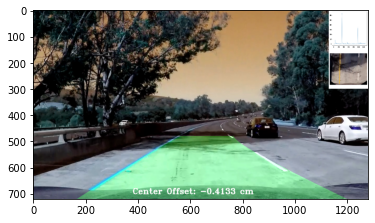

In [16]:
plt.figure()
plt.imshow(temp)

In [18]:
from moviepy.editor import VideoFileClip

In [19]:
#VID_INPUT = "project_video.mp4"
VID_INPUT = "project_video.mp4"
VID_OUT_DIR = "./video_results"
VID_OUTPUT_PATH = VID_OUT_DIR + "/project_video_result_alt_DF.mp4"

CO_THRES = 5
PIXEL_THRES = 600

if not os.path.exists(VID_OUT_DIR):
    os.makedirs(VID_OUT_DIR)

# Process each frame in the project video input and output a new video with lane lines projected
clip = VideoFileClip(VID_INPUT)
#new_clip = clip.fl_image(run_pipeline)
new_clip = clip.fl_image(run_alt_pipeline)
new_clip.write_videofile(VID_OUTPUT_PATH, fps=30)

Moviepy - Building video ./video_results/project_video_result_alt_DF.mp4.
MoviePy - Writing audio in project_video_result_alt_DFTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video ./video_results/project_video_result_alt_DF.mp4



Moviepy - Done !
Moviepy - video ready ./video_results/project_video_result_alt_DF.mp4
